<a href="https://colab.research.google.com/github/Mirthu24/Sequence_to_Sequence_Modelling_with_Attention_Mechanism/blob/main/Sequence2Sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchtext matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [3]:
# Importing the necessary libraries
import torch
import numpy as np
import random
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [4]:
# Checking for GPU Access
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

GPU Available: True
GPU Name: Tesla T4


In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to generate synthetic data
def generate_data(num_samples, seq_len, vocab_size):
    data = []
    for _ in range(num_samples):
        src = [random.randint(1, vocab_size - 1) for _ in range(seq_len)]  # Random sequence
        tgt = src[::-1]  # Reverse sequence as target
        data.append((src, tgt))
    return data

# Define parameters
vocab_size = 20             # Vocabulary size (words/integers)
seq_len = 30                # Length of each sequence
num_samples = 100000        # Number of training examples

# Generate dataset
data = generate_data(num_samples, seq_len, vocab_size)

# Print a sample
print("Example Source Sequence:", data[0][0])
print("Example Target (Reversed) Sequence:", data[0][1])

Example Source Sequence: [12, 15, 13, 17, 8, 9, 13, 2, 3, 4, 17, 14, 7, 7, 14, 9, 9, 14, 8, 6, 14, 2, 18, 9, 18, 19, 16, 12, 15, 10]
Example Target (Reversed) Sequence: [10, 15, 12, 16, 19, 18, 9, 18, 2, 14, 6, 8, 14, 9, 9, 14, 7, 7, 14, 17, 4, 3, 2, 13, 9, 8, 17, 13, 15, 12]


In [6]:
# Custom Dataset for Seq2Seq tasks
class Seq2SeqDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src, tgt = self.data[idx]
        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

# Initialize dataset and dataloader
dataset = Seq2SeqDataset(data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Check a sample batch
for src_batch, tgt_batch in dataloader:
    print("Source Batch Shape:", src_batch.shape)
    print("Target Batch Shape:", tgt_batch.shape)
    break  # Only print one batch


Source Batch Shape: torch.Size([32, 30])
Target Batch Shape: torch.Size([32, 30])


In [7]:
# Attention Module
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(1)
        H = hidden.repeat(max_len, 1, 1).transpose(0, 1)
        attn_energies = self.score(H, encoder_outputs)
        return torch.softmax(attn_energies, dim=1).unsqueeze(1)

    def score(self, hidden, encoder_outputs):
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(1, 2)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        energy = torch.bmm(v, energy)
        return energy.squeeze(1)

# Define model parameters
hidden_size = 512  # Same as LSTM hidden state size

# Initialize Attention
attention = Attention(hidden_size)

# Check the module
print(attention)


Attention(
  (attn): Linear(in_features=1024, out_features=512, bias=True)
)


In [8]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embed_size)  # Embedding Layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)  # LSTM Layer

    def forward(self, x):
        embedding = self.embedding(x)  # Convert input to embeddings
        outputs, (hidden, cell) = self.lstm(embedding)  # Pass through LSTM
        return outputs, hidden, cell  # Return all LSTM outputs and final hidden, cell states

# Define model parameters
embed_size = 256
num_layers = 2

# Initialize Encoder
encoder = Encoder(input_size = vocab_size, embed_size = embed_size, hidden_size = hidden_size, num_layers = num_layers).to(device)

# Check the module
print(encoder)

Encoder(
  (embedding): Embedding(20, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True)
)


In [9]:
class Decoder(nn.Module):
    def __init__(self, output_size, embed_size, hidden_size, num_layers, attention):
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.attention = attention
        self.embedding = nn.Embedding(output_size, embed_size)
        self.lstm = nn.LSTM(hidden_size + embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell, encoder_outputs):
        x = x.unsqueeze(1)
        embedding = self.embedding(x)
        attn_weights = self.attention(hidden[-1], encoder_outputs)  # [batch, 1, seq_len]
        context = attn_weights.bmm(encoder_outputs)                 # [batch, 1, hidden]
        rnn_input = torch.cat((embedding, context), dim=2)
        outputs, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))
        predictions = self.fc(outputs.squeeze(1))                   # [batch, vocab]
        return predictions, hidden, cell, attn_weights

# Initialize Decoder
decoder = Decoder(output_size=vocab_size, embed_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, attention=attention).to(device)

# Check the module
print(decoder)


Decoder(
  (attention): Attention(
    (attn): Linear(in_features=1024, out_features=512, bias=True)
  )
  (embedding): Embedding(20, 256)
  (lstm): LSTM(768, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=20, bias=True)
)


In [10]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.decoder.output_size

        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device)
        attentions = torch.zeros(batch_size, target_len, source.shape[1]).to(device)  # [batch, tgt_len, src_len]

        encoder_outputs, hidden, cell = self.encoder(source)
        x = target[:, 0]

        for t in range(1, target_len):
            output, hidden, cell, attn_weights = self.decoder(x, hidden, cell, encoder_outputs)
            outputs[:, t, :] = output
            attentions[:, t, :] = attn_weights.squeeze(1)  # Save attention weights
            teacher_force = random.random() < teacher_forcing_ratio
            x = target[:, t] if teacher_force else output.argmax(1)

        return outputs, attentions


# Initialize model
seq2seq = Seq2Seq(encoder, decoder).to(device)

# Check the model
print(seq2seq)


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(20, 256)
    (lstm): LSTM(256, 512, num_layers=2, batch_first=True)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(20, 256)
    (lstm): LSTM(768, 512, num_layers=2, batch_first=True)
    (fc): Linear(in_features=512, out_features=20, bias=True)
  )
)


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.001)

Epoch 1/10 - Loss: 0.2380
Epoch 2/10 - Loss: 0.1624
Epoch 3/10 - Loss: 0.0148
Epoch 4/10 - Loss: 0.0076
Epoch 5/10 - Loss: 0.0058
Epoch 6/10 - Loss: 0.0058
Epoch 7/10 - Loss: 0.0033
Epoch 8/10 - Loss: 0.0039
Epoch 9/10 - Loss: 0.0025
Epoch 10/10 - Loss: 0.0028
Training completed successfully!


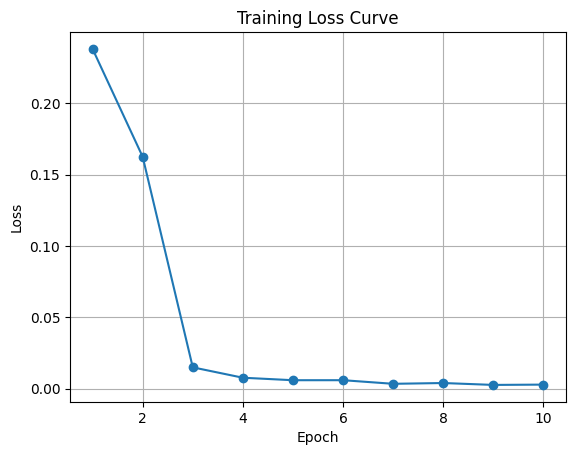

In [12]:
def train_model(model, dataloader, optimizer, criterion, num_epochs=10, teacher_forcing_ratio=0.5):
    model.train()
    loss_history = []

    for epoch in range(num_epochs):
        loss_list = []
        for source, target in dataloader:
            source, target = source.to(device), target.to(device)

            optimizer.zero_grad()
            # Unpack the outputs from the model
            outputs, _ = model(source, target, teacher_forcing_ratio)

            # Reshape output and target for loss computation
            output_dim = outputs.shape[-1]
            output = outputs[:, 1:].reshape(-1, output_dim)  # Ignore <SOS>
            target = target[:, 1:].reshape(-1)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            loss_list.append(loss.item())           # Append batch loss

        avg_loss = sum(loss_list) / len(loss_list)  # Compute average loss
        loss_history.append(avg_loss)               # Store average loss

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

    print("Training completed successfully!")
    return loss_history

# Train and store loss history
loss_history = train_model(seq2seq, dataloader, optimizer, criterion, num_epochs=10)

# Plot the loss curve
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()


In [13]:
def evaluate(model, dataloader):
    model.eval()
    total_correct = 0
    total_words = 0

    with torch.no_grad():
        for source, target in dataloader:
            source, target = source.to(device), target.to(device)
            # Get outputs and attentions from the model
            outputs, _ = model(source, target, 0)  # No teacher forcing during evaluation

            # Use outputs for argmax (it contains the predictions)
            output = outputs.argmax(dim=-1)  # Get predicted indices

            # Compare with actual target (ignoring <SOS> token)
            correct = (output[:, 1:] == target[:, 1:]).sum().item()
            total_correct += correct
            total_words += target[:, 1:].numel()

    accuracy = total_correct / total_words * 100
    print(f"Model Accuracy on Test Data: {accuracy:.2f}%")

# Run evaluation
evaluate(seq2seq, dataloader)


Model Accuracy on Test Data: 99.83%


In [14]:
seq2seq.eval()
with torch.no_grad():
    for i, (src, tgt) in enumerate(dataloader):
        src, tgt = src.to(device), tgt.to(device)

        # Unpack the output tuple into outputs and attentions
        outputs, attentions = seq2seq(src, tgt, teacher_forcing_ratio=0)

        # Use 'outputs' for further processing (it contains the model predictions)
        output = outputs[:, 1:].reshape(-1, outputs.shape[2])
        tgt = tgt[:, 1:].reshape(-1)

        pred = output.argmax(1).view(-1, seq_len-1)
        print(f'Source:\n {src[0].cpu().numpy()}')
        print(f'\nTarget:\n {tgt.view(-1, seq_len-1)[0].cpu().numpy()}')
        print(f'\nPredicted:\n {pred[0].cpu().numpy()}')
        break

Source:
 [ 6  9  6  4 14  8 14  5  2  6 11 13  9 15  7  9 18 16 13 19  3  8  2  6
  9  6 13 16 19 18]

Target:
 [19 16 13  6  9  6  2  8  3 19 13 16 18  9  7 15  9 13 11  6  2  5 14  8
 14  4  6  9  6]

Predicted:
 [19 16 13  6  9  6  2  8  3 19 13 16 18  9  7 15  9 13 11  6  2  5 14  8
 14  4  6  9  6]


In [17]:
# Saving the model in drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Defining path to Seq2Seq folder
save_path = "/content/drive/MyDrive/Seq2Seq/seq2seq_model.pth"

# Save the entire model
torch.save(seq2seq.state_dict(), save_path)
print(f"Model saved Successfully!")


Model saved Successfully!




---



**Loading the saved model and working on it**

In [20]:
# Loading the saved model from drive
loaded_model = Seq2Seq(encoder, decoder).to(device)
loaded_model.load_state_dict(torch.load(save_path))
loaded_model.eval()
print("Model loaded successfully!")

Model loaded successfully!


In [21]:
# Re-evaluating on the loaded model

evaluate(loaded_model, dataloader)

Model Accuracy on Test Data: 99.83%


Source Sequence:
 [16 10 10  2 18  2 13 18 13  2  1  9  5  8  8 13 18 10 16  3  1  7  4  4
 12 19 13 16 13 11]

Target Sequence:
 [11 13 16 13 19 12  4  4  7  1  3 16 10 18 13  8  8  5  9  1  2 13 18 13
  2 18  2 10 10 16]

Predicted Sequence:
 [ 0 13 16 13 19 12  4  4  7  1  3 16 10 18 13  8  8  5  9  1  2 13 18 13
  2 18  2 10 10 16]


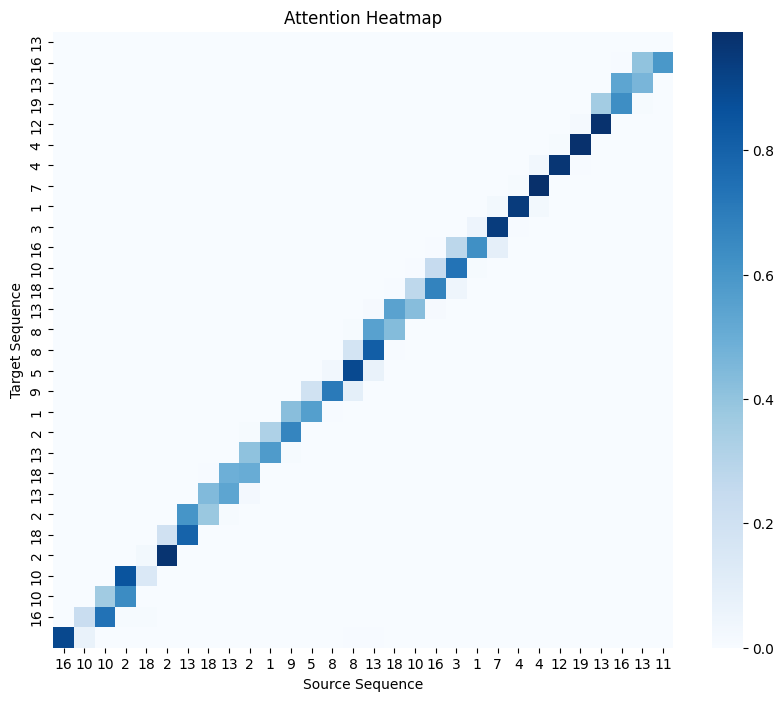

In [25]:
def visualize_attention(source_seq, target_seq, attention_weights):
    import seaborn as sns
    import numpy as np

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    attention = attention_weights.squeeze(0).cpu().detach().numpy()  # [tgt_len, src_len]

    sns.heatmap(attention, xticklabels=source_seq, yticklabels=target_seq[1:], cmap='Blues', cbar=True, ax=ax)
    ax.set_xlabel("Source Sequence")
    ax.set_ylabel("Target Sequence")
    plt.title("Attention Heatmap")
    plt.show()


#
seq2seq.eval()
with torch.no_grad():
    for src, tgt in dataloader:
        src, tgt = src.to(device), tgt.to(device)
        outputs, attentions = seq2seq(src, tgt, teacher_forcing_ratio=0)
        preds = outputs.argmax(2)

        # Convert to CPU lists
        source_seq = src[0].cpu().numpy()
        target_seq = tgt[0].cpu().numpy()
        attn_weights = attentions[0]  # Shape: [tgt_len, src_len]

        print("Source Sequence:\n", source_seq)
        print("\nTarget Sequence:\n", target_seq)
        print("\nPredicted Sequence:\n", preds[0].cpu().numpy())

        # Visualize
        visualize_attention(source_seq, target_seq, attn_weights)

        break  # Just one sample


In [26]:
# Create test dataset
test_data = generate_data(num_samples=1000, seq_len=30, vocab_size=vocab_size)
test_dataset = Seq2SeqDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=32)


def evaluate_model(model, dataloader):
    model.eval()
    total = 0
    correct = 0

    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)
            output, _ = model(src, tgt, teacher_forcing_ratio=0)
            predictions = output.argmax(dim=2)  # [batch, tgt_len]

            # Exclude the first token (start token) from accuracy
            correct += (predictions[:, 1:] == tgt[:, 1:]).sum().item()
            total += (tgt[:, 1:].numel())

    accuracy = correct / total
    print(f"Test Accuracy on Unseen Data: {accuracy * 100:.2f}%")


evaluate_model(seq2seq, test_loader)

Test Accuracy on Unseen Data: 99.92%
